<a href="https://colab.research.google.com/github/sesidhar-7/final_proj/blob/main/EfficientNetV2L_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install tensorflow-addons

In [1]:
pip install tensorflow==2.12.0 tensorflow-addons==0.20.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
 

In [2]:
from tensorflow.keras.applications import EfficientNetV2L
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
from tensorflow_addons.metrics import CohenKappa, F1Score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import kagglehub

In [4]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
# Download latest version
ROOT_DIRECTORY = kagglehub.dataset_download("sabari50312/fundus-pytorch")

print("Path to dataset files:", ROOT_DIRECTORY)
#ROOT_DIRECTORY = '/kaggle/input/fundus-pytorch'
LR = 0.0001
epochs = 20
fine_tuning_epochs = 20
total_epochs = epochs

100%|██████████| 3.82G/3.82G [00:43<00:00, 95.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sabari50312/fundus-pytorch/versions/1


In [7]:
#read images
def read_dataset(path):
    datagen = ImageDataGenerator(rescale = 1./255)

    train_dataset = datagen.flow_from_directory(os.path.join(path, "train"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')
    test_dataset = datagen.flow_from_directory(os.path.join(path, "test"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')
    val_dataset = datagen.flow_from_directory(os.path.join(path, "val"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')

    return train_dataset, test_dataset, val_dataset

In [8]:
train_dataset, test_dataset, val_dataset = read_dataset(ROOT_DIRECTORY)

Found 8621 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.


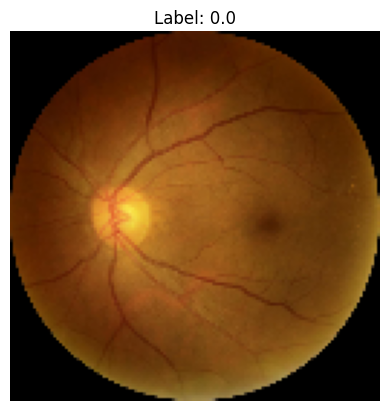

In [9]:

images, labels = next(train_dataset)

# Print the first image
plt.imshow(images[0])
plt.title("Label: " + str(labels[0]))
plt.axis('off')
plt.show()

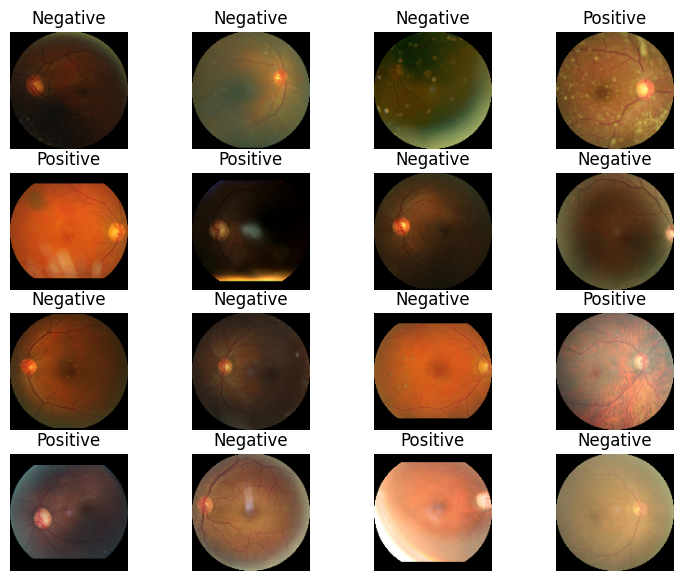

In [10]:
batch = next(train_dataset)
images, labels = batch

n_cols = 4
n_rows = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize = (9, 7))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].imshow(images[i * n_cols + j])
        ax[i][j].set_title("Positive" if labels[i * n_cols + j] == 1.0 else "Negative")
        ax[i][j].axis("off")
plt.show()

In [5]:
!pip install --quiet vit-keras

from vit_keras import vit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00


In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    print("Building model...\n")
    base_model = EfficientNetV2L(include_top = False, weights = 'imagenet', input_shape = TARGET_SIZE + (3,))

    base_model.trainable = True

    model = tf.keras.Sequential()

    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(8, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))


    model.summary()


    metrics = [
       tf.keras.metrics.TruePositives(name = 'tp'),
        tf.keras.metrics.TrueNegatives(name = 'tn'),
        tf.keras.metrics.FalsePositives(name = 'fp'),
        tf.keras.metrics.FalseNegatives(name = 'fn'),
        tf.keras.metrics.BinaryAccuracy(name = 'acc'),
        tf.keras.metrics.Recall(name = 'r'),
        tf.keras.metrics.Precision(name = 'p'),
        F1Score(num_classes = 2, threshold = 0.5, average='micro', name = 'F1')
    ]

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor = 0.3)]

    print("Compiling...\n")

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = metrics,
    )
    print("Finished!\n")

    print("Fitting...\n")
    history_fit = model.fit(
        train_dataset,
        validation_data = val_dataset,
        batch_size = BATCH_SIZE,
        epochs = 50,
        verbose = 1,
        callbacks = callbacks,
        shuffle = True,
        initial_epoch = 0,
    )
    print("Finished!\n")

Building model...

473176280/473176280 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 4, 4, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                  

2024-04-12 09:26:16.480957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


539/539 [==============================] - 411s 381ms/step - loss: 0.4671 - tp: 2138.0000 - tn: 4633.0000 - fp: 660.0000 - fn: 1190.0000 - acc: 0.7854 - r: 0.6424 - p: 0.7641 - F1: 0.6980 - val_loss: 0.3057 - val_tp: 1678.0000 - val_tn: 3345.0000 - val_fp: 194.0000 - val_fn: 530.0000 - val_acc: 0.8740 - val_r: 0.7600 - val_p: 0.8964 - val_F1: 0.8225 - lr: 1.0000e-04
Epoch 2/50
539/539 [==============================] - 191s 354ms/step - loss: 0.3474 - tp: 2506.0000 - tn: 4844.0000 - fp: 449.0000 - fn: 822.0000 - acc: 0.8526 - r: 0.7530 - p: 0.8481 - F1: 0.7977 - val_loss: 0.3535 - val_tp: 1373.0000 - val_tn: 3457.0000 - val_fp: 82.0000 - val_fn: 835.0000 - val_acc: 0.8404 - val_r: 0.6218 - val_p: 0.9436 - val_F1: 0.7497 - lr: 1.0000e-04
Epoch 3/50
539/539 [==============================] - 192s 355ms/step - loss: 0.2898 - tp: 2650.0000 - tn: 4929.0000 - fp: 364.0000 - fn: 678.0000 - acc: 0.8791 - r: 0.7963 - p: 0.8792 - F1: 0.8357 - val_loss: 0.2103 - val_tp: 1879.0000 - val_tn: 3397.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



539/539 [==============================] - 187s 347ms/step - loss: 0.0055 - tp: 3325.0000 - tn: 5274.0000 - fp: 19.0000 - fn: 3.0000 - acc: 0.9974 - r: 0.9991 - p: 0.9943 - F1: 0.9967 - val_loss: 0.0031 - val_tp: 2208.0000 - val_tn: 3528.0000 - val_fp: 11.0000 - val_fn: 0.0000e+00 - val_acc: 0.9981 - val_r: 1.0000 - val_p: 0.9950 - val_F1: 0.9975 - lr: 3.0000e-05
Epoch 43/50
539/539 [==============================] - 183s 340ms/step - loss: 0.0041 - tp: 3325.0000 - tn: 5275.0000 - fp: 18.0000 - fn: 3.0000 - acc: 0.9976 - r: 0.9991 - p: 0.9946 - F1: 0.9969 - val_loss: 0.0056 - val_tp: 2205.0000 - val_tn: 3527.0000 - val_fp: 12.0000 - val_fn: 3.0000 - val_acc: 0.9974 - val_r: 0.9986 - val_p: 0.9946 - val_F1: 0.9966 - lr: 3.0000e-05
Epoch 44/50
539/539 [==============================] - 184s 341ms/step - loss: 0.0057 - tp: 3324.0000 - tn: 5274.0000 - fp: 19.0000 - fn: 4.0000 - acc: 0.9973 - r: 0.9988 - p: 0.9943 - F1: 0.9966 - val_loss: 0.0032 - val_tp: 2208.0000 - val_tn: 3527.0000 - val

In [ ]:
results = model.evaluate(test_dataset)

180/180 [==============================] - 58s 325ms/step - loss: 0.0028 - tp: 1117.0000 - tn: 1753.0000 - fp: 1.0000 - fn: 3.0000 - acc: 0.9986 - r: 0.9973 - p: 0.9991 - F1: 0.9982


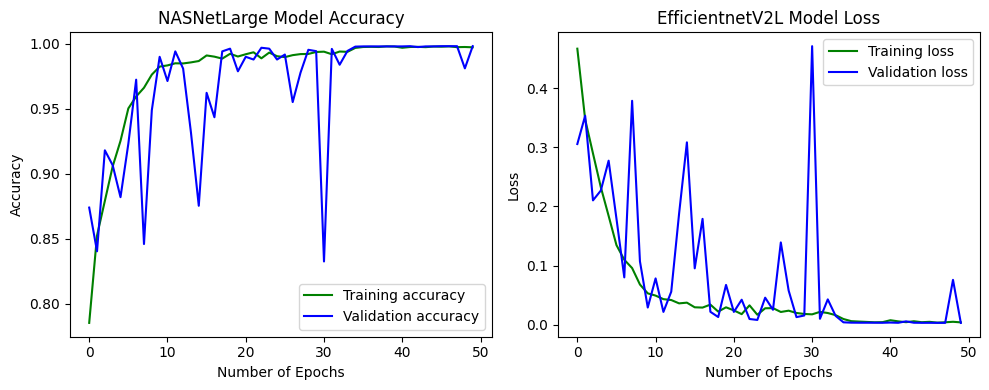

In [ ]:
loss_train = history_fit.history['loss']
loss_val = history_fit.history['val_loss']
accuracy_train = history_fit.history['acc']
accuracy_val = history_fit.history['val_acc']

plt.figure(figsize=(10, 4))
# Plotting loss curve
plt.subplot(1, 2, 1)
plt.title('NASNetLarge Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.legend()

# Plotting accuracy curve
plt.subplot(1, 2, 2)

plt.title('EfficientnetV2L Model Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.legend()

plt.tight_layout()  # To adjust the spacing between subplots

# Set the height and width of the plot


plt.show()

In [ ]:
confusion_matrix = [
    [results[2], results[4]],
    [results[3], results[1]],
]

Text(50.722222222222214, 0.5, 'True Label')

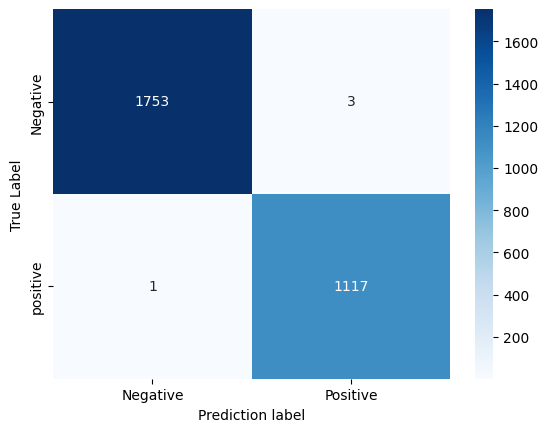

In [ ]:
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", cmap = 'Blues', xticklabels = ["Negative", "Positive"], yticklabels = ["Negative", "positive"])
plt.xlabel("Prediction label")
plt.ylabel("True Label")